In [73]:
def make_text_file(filename, outfile, limit=1000):
    '''Read CONLLU file and export TXT with the sentences'''
    with open(filename, "r", encoding='utf8') as f, open(outfile, 'w', encoding='utf8') as o:
        i=0
        o.write('<text>\n')
        for line in f:
            if line[:9] == '# text = ': 
                text = line[9:]
                i+=1
                o.write('<sentence>\n')
                o.write(text)
                o.write('</sentence>\n')
                if i==limit:
                    break
        o.write('</text>\n')
    print(f'Wrote {i} sentences to file.')

In [74]:
make_text_file('conllu-files/en_formal.conllu', 'en_formal.txt')
make_text_file('conllu-files/en_literature.conllu', 'en_literature.txt')
make_text_file('conllu-files/en_news.conllu', 'en_news.txt')

Wrote 1000 sentences to file.
Wrote 1000 sentences to file.
Wrote 1000 sentences to file.


In [126]:
make_text_file('conllu-files/sv_formal.conllu', 'sv_formal.txt')
make_text_file('conllu-files/sv_literature.conllu', 'sv_literature.txt')
make_text_file('conllu-files/sv_news.conllu', 'sv_news.txt')

Wrote 1000 sentences to file.
Wrote 1000 sentences to file.
Wrote 1000 sentences to file.


In [2]:
def read_conllu(filename, limit=1000):
    '''Returns a dict of (sent_tokens...):{'upos':[upos_tags...], 'xpos':[xpos_tags}'''
    
    with open(filename, "r", encoding='utf8') as f:
        
        sentences = {}
        tokens = []
        upos_tags = []
        xpos_tags = []
        deprels = []
        
        
        for line in f:
            if line[0] == '#': #skip '# newdoc id = n01001', '# sent_id = n01001011'
                continue
            columns = line.split() # 10 cols
            if columns == []: # When reading a blank line => finish reading one sentence
                sentence_text = tuple(tokens)
                sentences[sentence_text] = {}
                sentences[sentence_text]['upos'] = upos_tags
                sentences[sentence_text]['xpos'] = xpos_tags
                sentences[sentence_text]['deprel'] = deprels
                tokens, upos_tags, xpos_tags, deprels = [], [], [], [] # Reset the pos lists
                
                
                if len(sentences)>=limit:
                    break
                continue
                
            tokens.append(columns[1])
            upos_tags.append(columns[3])
            xpos_tags.append(columns[4].split('|')[0]) # if XX|YY|ZZ => only keep XX
            deprels.append(columns[6]+'_'+columns[7]) # head id, deprel tag
            

            
    print(f'Corpus contains {len(sentences)} sentences.')
    return sentences

In [3]:
# key = tuple of tokens of a sentence
# dict[key]['upos'] = true POS labels
eng_formal = read_conllu('conllu-files/en_formal.conllu')
eng_literature = read_conllu('conllu-files/en_literature.conllu')
eng_news = read_conllu('conllu-files/en_news.conllu')

swe_formal = read_conllu('conllu-files/sv_formal.conllu')
swe_literature = read_conllu('conllu-files/sv_literature.conllu')
swe_news = read_conllu('conllu-files/sv_news.conllu')


Corpus contains 1000 sentences.
Corpus contains 1000 sentences.
Corpus contains 1000 sentences.
Corpus contains 1000 sentences.
Corpus contains 1000 sentences.
Corpus contains 1000 sentences.


In [4]:
import re
def read_sparv_xml(filename):
    '''Reads the XML file from Sparv annotation and return the texts and 
    the POS and MSD tags'''
    with open(filename, "r", encoding='utf8') as f:
        
        sentences = {}
        
        for line in f:
            if line[:3]=='<se':
                tokens = []
                pos_tags = []
                msd_tags = []
                deprels = [] 
                
            if line[:3]=='<w ':
                token = re.findall('(?<=>)[^\s]+(?=</w>)', line)[0]
                pos = re.findall('(?<=pos=")[^\s]+(?="\sm)', line)[0]
                msd = re.findall('(?<=msd=")[^\s]+(?="\s)', line)[0]
                try:
                    head_id = re.findall('(?<=dephead=")[^\s]*(?="\s)', line)[0]
                    deprel_tag = re.findall('(?<=deprel=")[^\s]+(?=">)', line)[0]
                    
                except IndexError:
                    head_id, deprel_tag = '_', '_'
                
                if msd[0]=='F' and msd[1:].islower():
                    msd = token # change tag to the punctuation itself
                if pos in ('PROPN','PM') and len(token.split('_'))>1: #split multiword PropN 
                    propn_tokens = token.split('_')
                    tokens.extend(propn_tokens)
                    pos_tags.extend([pos]*len(propn_tokens))
                    msd_tags.extend([msd]*len(propn_tokens))
                    deprels.extend([head_id+'_'+deprel_tag]*len(propn_tokens))
                    continue
                
                tokens.append(token)
                pos_tags.append(pos)
                msd_tags.append(msd)
                deprels.append(head_id+'_'+deprel_tag)
            
            if line[:3]=='</s':
                sentence_text = tuple(tokens)
                sentences[sentence_text] = {}
                sentences[sentence_text]['pos'] = pos_tags
                sentences[sentence_text]['msd'] = msd_tags
                sentences[sentence_text]['deprel'] = deprels
                
    print(f'Parser output contains {len(sentences)} sentences.')       
    return sentences


In [5]:
# key = tuple of tokenized sentence
# dict[key]['pos'] = predicted POS labels
sparv_en_news = read_sparv_xml('parsed/en_news_parsed.xml')
sparv_sv_news = read_sparv_xml('parsed/sv_news_parsed.xml')

sparv_en_lit = read_sparv_xml('parsed/en_lit_parsed.xml')
sparv_sv_lit = read_sparv_xml('parsed/sv_lit_parsed.xml')

sparv_en_formal = read_sparv_xml('parsed/en_formal_parsed.xml')
sparv_sv_formal = read_sparv_xml('parsed/sv_formal_parsed.xml')


Parser output contains 986 sentences.
Parser output contains 993 sentences.
Parser output contains 948 sentences.
Parser output contains 1025 sentences.
Parser output contains 866 sentences.
Parser output contains 911 sentences.


In [6]:
def shared_keys(dict1, dict2):
    d1_set = set(dict1)
    d2_set = set(dict2)
    return d1_set.intersection(d2_set)

In [138]:
from typing import List, Dict
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

def model_performance(y_true: List[List[str]],
                      y_pred: List[List[str]]) -> Dict[str, float]:
    """Accuracy calculation function
    
    Args:
      y_true: List of true labels of the tokenized sentense.
      y_pred: List of predicted labels of the tokenized sentense.
      
    Returns:
      Dict of metrics:
      
        {
          "accuracy": float,
          "f1_micro": float,
          "f1_macro": float,
          "f1_weighted": float,
        }
    
    Raises:
      ValueError: Exception occurred when input lists' length don't match.
    """
    if len(y_true) == 0:
        return None
    
    if len(y_true) != len(y_pred):
        raise ValueError("Lengths of input lists don't match.")
    
    def _list_flattener(inpt: List[List[str]]) -> List[str]:
        """Flattener for list of lists into a single list."""
        output = []
        for i in inpt:
            output.extend(i)
        return output

    y_true = _list_flattener(y_true)
    y_pred = _list_flattener(y_pred)

    if len(y_true) != len(y_pred):
        raise ValueError("Numper of tokens don't match between y_true and y_pred.")
    
    try:
        metrics = {
          "accuracy": accuracy_score(y_true, y_pred),
          "f1_micro": f1_score(y_true, y_pred, average='micro'),
          "f1_macro": f1_score(y_true, y_pred, average='macro'),
          "f1_weighted": f1_score(y_true, y_pred, average='weighted'),
        }
    except Exception as ex:
        raise Exception(f"Metrics calculation error: {ex}")
    return metrics

import random
from mlxtend.plotting import plot_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
def eval_domain(corpora_dict, sparv_dict, lang='en', sample_size=500, domain_name=''):
    
    common_keys = shared_keys(corpora_dict, sparv_dict)
    common_keys = list(common_keys)
    print(f'UD corpora has {len(corpora_dict)} sentences.')
    print(f'Sparv parsing has {len(sparv_dict)} sentences.')
    print(f'{len(common_keys)} sentences in common.')
    
    
    true_pos = [corpora_dict[key]['upos'] for key in common_keys]
    if lang=='en':
        pred_pos = [sparv_dict[key]['pos'] for key in common_keys]
    if lang=='sv':
        sv_pos_mapping = {'AB':'ADV', 'DT':'DET','HA':'ADV','HD':'DET','HP':'PRON','HS':'PRON',
                     'IE':'PART','IN':'INTJ','JJ':'ADJ','KN':'CCONJ','MAD':'PUNCT','MID':'PUNCT', 
                    'NN':'NOUN','PAD':'PUNCT','PC':'ADJ','PL':'ADV','PM':'PROPN','PN':'PRON',
                 'PP':'ADP','PS':'PRON','RG':'NUM','RO':'ADJ','SN':'SCONJ','UO':'NOUN','VB':'VERB'}
        pred_pos = [ [sv_pos_mapping[p] for p in sparv_dict[key]['pos']]
                    for key in common_keys]
        
    true_pos, pred_pos = zip(*random.sample(list(zip(true_pos, pred_pos)), sample_size))
    print(f'Evaluate {len(true_pos)} sentences and their POS tagging prediction.')
    print()
    results = model_performance(true_pos, pred_pos)
    for x in results.items():
        print(x)
    
    def flatten(inpt: List[List[str]]) -> List[str]:
        output = []
        for i in inpt:
            output.extend(i)
        return output
    labels = sorted(list(set(flatten(true_pos))))
    print(f'{len(labels)} true labels:', labels)
    confusion = confusion_matrix(flatten(true_pos), flatten(pred_pos), labels=labels)
#     print(confusion)
#     ConfusionMatrixDisplay(confusion)
    figure, ax = plot_confusion_matrix(conf_mat = confusion,
                                       class_names = labels,
                                       show_absolute = True,
                                       show_normed = False,
                                       colorbar = False,
                                      figsize=(10,10),
                               
                                      )
    
#     ax= plt.subplot()
#     sns.heatmap(confusion, annot=False, fmt='g', ax=ax);  
#     #annot=True to annotate cells, ftm='g' to disable scientific notation



    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix: '+domain_name);
#     ax.xaxis.set_ticklabels(labels); 
#     ax.yaxis.set_ticklabels(labels);
    plt.show()
    
     

### Evaluations

UD corpora has 1000 sentences.
Sparv parsing has 986 sentences.
674 sentences in common.
Evaluate 500 sentences and their POS tagging prediction.

('accuracy', 0.8262355928892362)
('f1_micro', 0.8262355928892362)
('f1_macro', 0.5514454403209098)
('f1_weighted', 0.8018820077578365)
16 true labels: ['ADJ', 'ADP', 'ADV', 'AUX', 'CCONJ', 'DET', 'INTJ', 'NOUN', 'NUM', 'PART', 'PRON', 'PROPN', 'PUNCT', 'SCONJ', 'VERB', 'X']


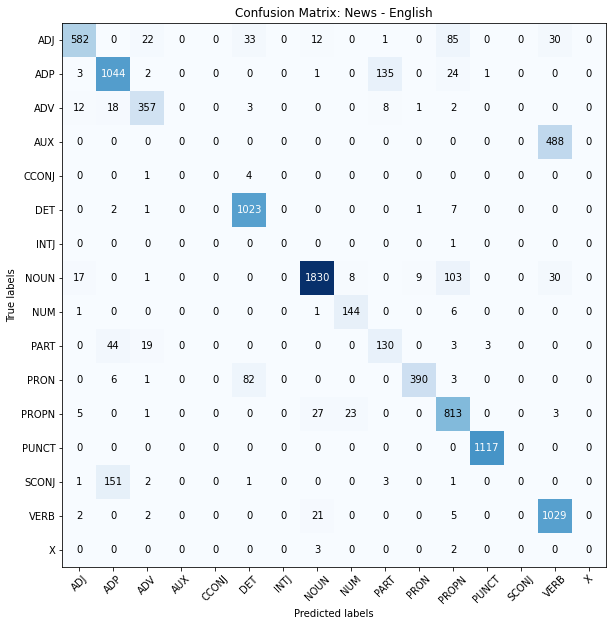

In [139]:
# News - English
eval_domain(eng_news, sparv_en_news, domain_name='News - English')

UD corpora has 1000 sentences.
Sparv parsing has 866 sentences.
563 sentences in common.
Evaluate 500 sentences and their POS tagging prediction.

('accuracy', 0.8065184216263352)
('f1_micro', 0.8065184216263352)
('f1_macro', 0.5346390074224859)
('f1_weighted', 0.7795312911154331)
16 true labels: ['ADJ', 'ADP', 'ADV', 'AUX', 'CCONJ', 'DET', 'INTJ', 'NOUN', 'NUM', 'PART', 'PRON', 'PROPN', 'PUNCT', 'SCONJ', 'VERB', 'X']


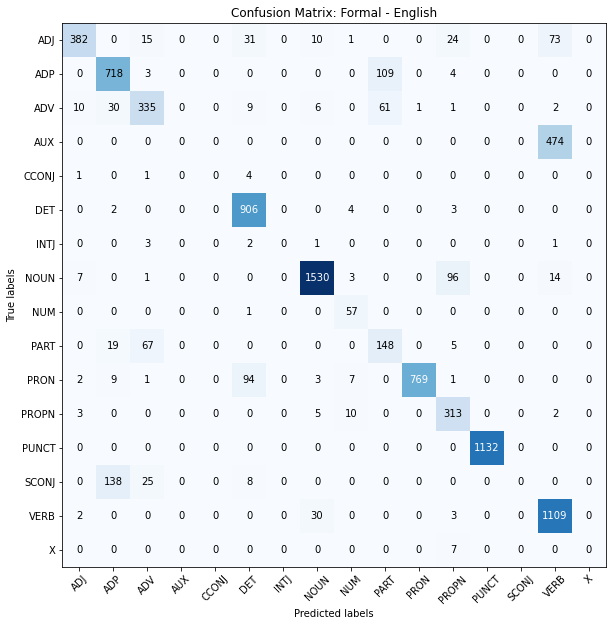

In [140]:
# Formal - English
eval_domain(eng_formal, sparv_en_formal, domain_name='Formal - English')

UD corpora has 1000 sentences.
Sparv parsing has 948 sentences.
680 sentences in common.
Evaluate 500 sentences and their POS tagging prediction.

('accuracy', 0.815643695989364)
('f1_micro', 0.815643695989364)
('f1_macro', 0.5732755087798562)
('f1_weighted', 0.7891988322756018)
15 true labels: ['ADJ', 'ADP', 'ADV', 'AUX', 'CCONJ', 'DET', 'INTJ', 'NOUN', 'NUM', 'PART', 'PRON', 'PROPN', 'PUNCT', 'SCONJ', 'VERB']


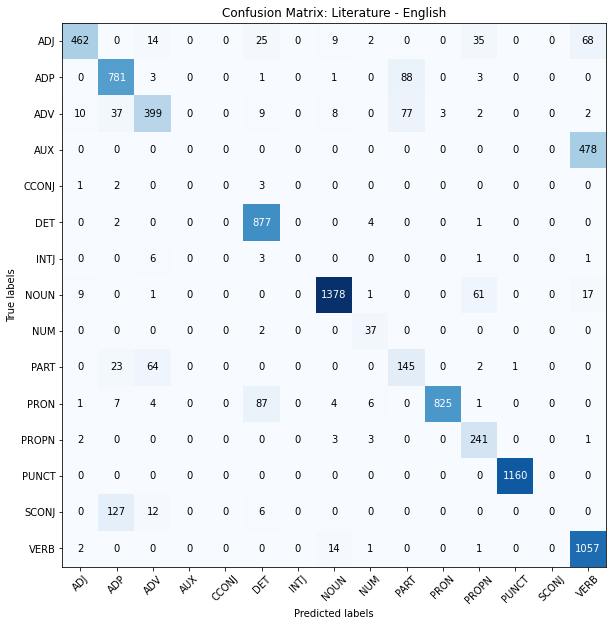

In [141]:
# Lit - English
eval_domain(eng_literature, sparv_en_lit, domain_name='Literature - English')

UD corpora has 1000 sentences.
Sparv parsing has 993 sentences.
941 sentences in common.
Evaluate 500 sentences and their POS tagging prediction.

('accuracy', 0.9152848639455783)
('f1_micro', 0.9152848639455783)
('f1_macro', 0.8341959475374429)
('f1_weighted', 0.8988532111376835)
15 true labels: ['ADJ', 'ADP', 'ADV', 'AUX', 'CCONJ', 'DET', 'INTJ', 'NOUN', 'NUM', 'PART', 'PRON', 'PROPN', 'PUNCT', 'SCONJ', 'VERB']


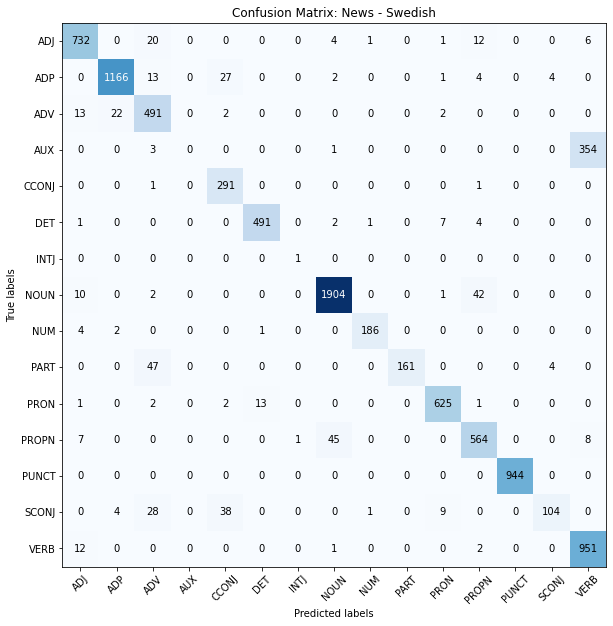

In [142]:
# News - Swedish
eval_domain(swe_news, sparv_sv_news, lang='sv', domain_name='News - Swedish')

UD corpora has 1000 sentences.
Sparv parsing has 911 sentences.
763 sentences in common.
Evaluate 500 sentences and their POS tagging prediction.

('accuracy', 0.9000916590284143)
('f1_micro', 0.9000916590284143)
('f1_macro', 0.7913638249539316)
('f1_weighted', 0.8805418289694285)
16 true labels: ['ADJ', 'ADP', 'ADV', 'AUX', 'CCONJ', 'DET', 'INTJ', 'NOUN', 'NUM', 'PART', 'PRON', 'PROPN', 'PUNCT', 'SCONJ', 'VERB', 'X']


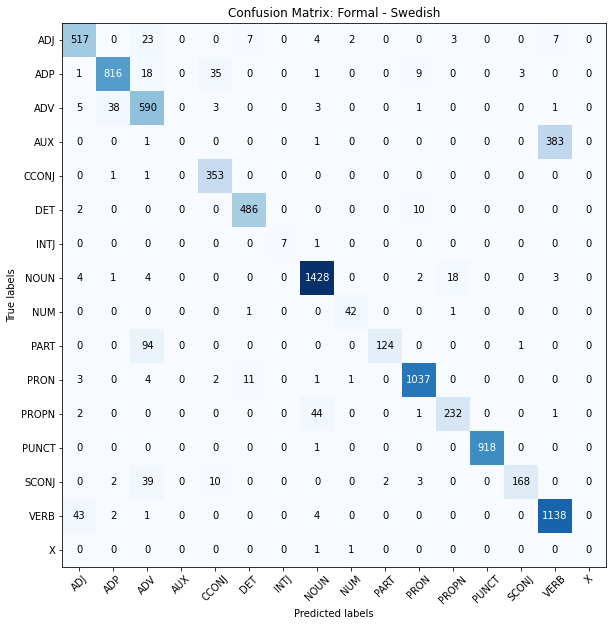

In [143]:
# Formal - Swedish
eval_domain(swe_formal, sparv_sv_formal, lang='sv', domain_name='Formal - Swedish')

UD corpora has 1000 sentences.
Sparv parsing has 1025 sentences.
935 sentences in common.
Evaluate 500 sentences and their POS tagging prediction.

('accuracy', 0.9044275846450006)
('f1_micro', 0.9044275846450006)
('f1_macro', 0.8458252493594468)
('f1_weighted', 0.8859272976101329)
15 true labels: ['ADJ', 'ADP', 'ADV', 'AUX', 'CCONJ', 'DET', 'INTJ', 'NOUN', 'NUM', 'PART', 'PRON', 'PROPN', 'PUNCT', 'SCONJ', 'VERB']


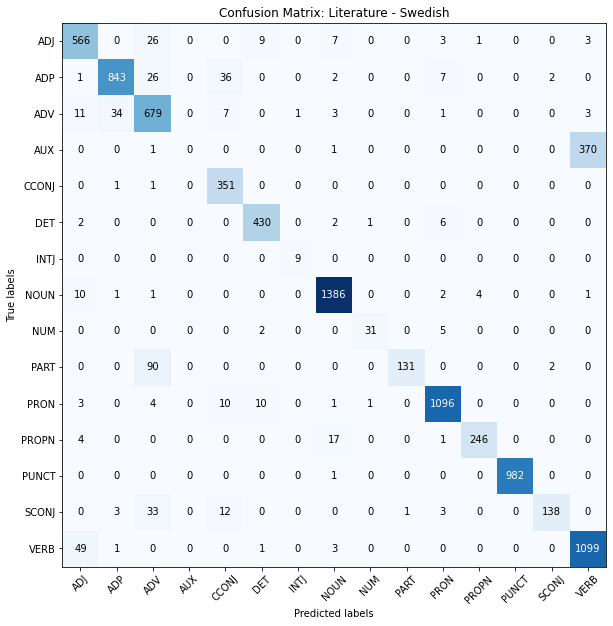

In [144]:
# Lit - Swedish
eval_domain(swe_literature, sparv_sv_lit, lang='sv', domain_name='Literature - Swedish')

In [102]:
def eng_to_swe_equivalent(eng_corpus, swe_corpus, out_fn):
    
    with open(out_fn, "w", encoding='utf8') as o:
    
        for eng_corpora, swe_corpora in list(zip(eng_corpus,swe_corpus)):
            with open(eng_corpora, "r", encoding='utf8') as en, open(swe_corpora, "r", encoding='utf8') as sv:

                swe_sent_ids = []
                for line in en:
                    if line[:14] == '# sent_id = en': # sent_id = en_lines-ud-dev-doc2-3296
                        swe_sent_id = 'sv' + line[14:].rstrip('\n')
                        swe_sent_ids.append(swe_sent_id)


                sv_lines = [l.rstrip('\n') for l in sv]
                for line in sv_lines:
                    if line[:12] == '# sent_id = ':
                        send_id = line[12:]
                        if send_id in swe_sent_ids:
                            i = sv_lines.index(line)
                            while sv_lines[i]!='':
                                o.write(sv_lines[i]+'\n') # write send_id ~ last token
                                i+=1
                            o.write('\n')
        
            

In [103]:

eng_to_swe_equivalent([f'domains/literature/en_lines-ud-{x}.conllu' for x in ['train', 'dev', 'test']], 
                     [f'UD/UD_Swedish-LinES/sv_lines-ud-{x}.conllu' for x in ['train', 'dev', 'test']],
                     'sv_literature.conllu')

In [107]:
def merge_corpus(corpus, out_fn):
    with open(out_fn, "w", encoding='utf8') as o:
        for corpora in corpus:
            with open(corpora, "r", encoding='utf8') as f:
                for line in f:
                    o.write(line)
merge_corpus([f'domains/literature/en_lines-ud-{x}.conllu' for x in ['train', 'dev', 'test']],
            'en_literature.conllu')


In [113]:
def formal_corpus(lines_fn, lit_fn, out_fn):
    # LinEs - Literature = formal
    with open(out_fn, "w", encoding='utf8') as o:

        with open(lines_fn, "r", encoding='utf8') as lines, open(lit_fn, "r", encoding='utf8') as lit:
            
            lit_ids = []
            for line in lit:
                if line[:14] == '# sent_id = en': # sent_id = en_lines-ud-dev-doc2-3296
                    lit_id = 'sv' + line[12:].rstrip('\n')
                    lit_ids.append(lit_id)
                    
            lines_l = [l.rstrip('\n') for l in lines]
            for line in lines_l:
                if line[:12] == '# sent_id = ':
                    send_id = line[12:]
                    if send_id not in lit_ids:
                        i = lines_l.index(line)
                        while lines_l[i]!='':
                            o.write(lines_l[i]+'\n') # write send_id ~ last token
                            i+=1
                        o.write('\n')
                            


In [218]:
sv_pos = set()
for c in (sparv_sv_formal, sparv_sv_lit, sparv_sv_news):
    
    for v in c.values():
        some_pos = v['pos']
        sv_pos.update(some_pos)
    
len(sv_pos)
sv_pos

{'AB',
 'DT',
 'HA',
 'HD',
 'HP',
 'HS',
 'IE',
 'IN',
 'JJ',
 'KN',
 'MAD',
 'MID',
 'NN',
 'PAD',
 'PC',
 'PL',
 'PM',
 'PN',
 'PP',
 'PS',
 'RG',
 'RO',
 'SN',
 'UO',
 'VB'}

In [216]:
sv_ud_pos = set()
for c in (swe_formal, swe_literature, swe_news):
    
    for v in c.values():
        some_pos = v['xpos']
        sv_ud_pos.update(some_pos)
    
len(sv_ud_pos)
sv_ud_pos

{'000',
 '15',
 '3',
 'AB',
 'AD-DEF',
 'AD-DEF-GEN',
 'AD-PL-DEF',
 'AD-PL-IND',
 'AD-SG-IND',
 'ADJ-PL',
 'ADJ-PL-GEN',
 'ADJ-PL-NOM',
 'ADJ-SG',
 'ADJ-SG-IND',
 'AUX',
 'CARD',
 'CARD-PL',
 'CARD-SG',
 'CMP',
 'CMP-DEF',
 'CMP-IND',
 'CMP-PL-IND',
 'CNJ',
 'Colon',
 'Comma',
 'DEF-FGN',
 'DEF-NOM',
 'DEM-PL',
 'DEM-SG',
 'DEM-SG-IND',
 'DT',
 'Dash',
 'Dots',
 'EX-P3SG',
 'ExclMark',
 'FGN',
 'FGN-NOM',
 'HA',
 'HD',
 'HP',
 'HS',
 'ID',
 'IE',
 'IM',
 'IMP-ACT',
 'IN',
 'IND',
 'IND-GEN',
 'IND-NOM',
 'IND-PFX',
 'IND-PL',
 'IND-SG',
 'IND-SG-NOM',
 'INF-ACT',
 'INF-AUX',
 'INF-DPO',
 'INF-PASS',
 'JJ',
 'KN',
 'LeftParenthesis',
 'MAD',
 'MID',
 'NDE',
 'NDE-NOM',
 'NEG',
 'NEG-PL-IND',
 'NEG-SG',
 'NEG-SG-IND',
 'NN',
 'NOM',
 'NOM-FGN',
 'NOUN',
 'ORD',
 'P1PL-GEN-PL',
 'P1PL-GEN-SG',
 'P1SG-GEN-PL',
 'P1SG-GEN-SG',
 'P2PL-GEN-PL',
 'P2PL-GEN-SG',
 'P2SG-GEN-PL',
 'P2SG-GEN-SG',
 'P3PL-GEN',
 'P3SG-GEN',
 'PAD',
 'PAST',
 'PAST-ACT',
 'PAST-AUX',
 'PAST-DPO',
 'PAST-PASS',
 'PC'

In [214]:
en_pos = set()
# for c in (sparv_en_formal, sparv_en_lit, sparv_en_news):
for c in (eng_formal, eng_literature, eng_news):
    
    for v in c.values():
        some_pos = v['xpos']
        en_pos.update(some_pos)
    
len(en_pos)

157

In [16]:
def print_difference(corpora_dict, sparv_dict, lang='en', max_tokens=10):
    
    common_keys = shared_keys(corpora_dict, sparv_dict)
    common_keys = list(common_keys)
    print(f'UD corpora has {len(corpora_dict)} sentences.')
    print(f'Sparv parsing has {len(sparv_dict)} sentences.')
    print(f'{len(common_keys)} sentences in common.')
    print(f'Evaluate {len(common_keys)} sentences and their POS tagging prediction.')
    print()
    
    true_pos = [corpora_dict[key]['upos'] for key in common_keys]
    if lang=='en':
        pred_pos = [sparv_dict[key]['pos'] for key in common_keys]
    if lang=='sv':
        sv_pos_mapping = {'AB':'ADV', 'DT':'DET','HA':'ADV','HD':'DET','HP':'PRON','HS':'PRON',
                     'IE':'PART','IN':'INTJ','JJ':'ADJ','KN':'CCONJ','MAD':'PUNCT','MID':'PUNCT', 
                    'NN':'NOUN','PAD':'PUNCT','PC':'ADJ','PL':'ADV','PM':'PROPN','PN':'PRON',
                 'PP':'ADP','PS':'PRON','RG':'NUM','RO':'ADJ','SN':'SCONJ','UO':'NOUN','VB':'VERB'}
        pred_pos = [ [sv_pos_mapping[p] for p in sparv_dict[key]['pos']]
                    for key in common_keys]
        
    
    for i in range(len(common_keys)):
        if true_pos[i]!=pred_pos[i] and len(common_keys[i])<=max_tokens:
            print(" ".join(common_keys[i]))
            print('true:', true_pos[i])
            print('pred:', pred_pos[i])
            print()

In [18]:
print_difference(eng_news, sparv_en_news, max_tokens=8)

UD corpora has 1000 sentences.
Sparv parsing has 986 sentences.
674 sentences in common.
Evaluate 674 sentences and their POS tagging prediction.

I also struggle with passwords .
true: ['PRON', 'ADV', 'VERB', 'ADP', 'NOUN', 'PUNCT']
pred: ['PRON', 'ADV', 'NOUN', 'ADP', 'NOUN', 'PUNCT']

They generally do not explode catastrophically .
true: ['PRON', 'ADV', 'AUX', 'PART', 'VERB', 'ADV', 'PUNCT']
pred: ['PRON', 'ADV', 'VERB', 'ADV', 'VERB', 'ADV', 'PUNCT']

The ruins were later built over .
true: ['DET', 'NOUN', 'AUX', 'ADV', 'VERB', 'ADP', 'PUNCT']
pred: ['DET', 'NOUN', 'VERB', 'ADV', 'VERB', 'ADP', 'PUNCT']

Kühn can only shake his head .
true: ['PROPN', 'AUX', 'ADV', 'VERB', 'PRON', 'NOUN', 'PUNCT']
pred: ['PROPN', 'VERB', 'ADV', 'VERB', 'PRON', 'NOUN', 'PUNCT']

I spotted a few .
true: ['PRON', 'VERB', 'DET', 'ADJ', 'PUNCT']
pred: ['PRON', 'VERB', 'DET', 'DET', 'PUNCT']

The dress is contemporary .
true: ['DET', 'NOUN', 'AUX', 'ADJ', 'PUNCT']
pred: ['DET', 'NOUN', 'VERB', 'ADJ', 'PU

In [20]:
'''
Then the commercial ends .
true: ['ADV', 'DET', 'NOUN', 'VERB', 'PUNCT']
pred: ['ADV', 'DET', 'ADJ', 'NOUN', 'PUNCT']
'''
model_performance([['ADV', 'DET', 'NOUN', 'VERB', 'PUNCT']],[['ADV', 'DET', 'ADJ', 'NOUN', 'PUNCT']] )


{'accuracy': 0.6, 'f1_micro': 0.6, 'f1_macro': 0.5, 'f1_weighted': 0.6}

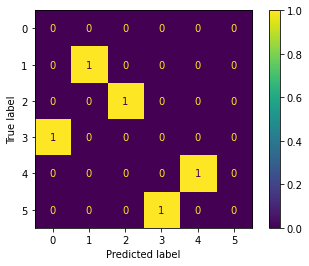

In [63]:
# Sample size = 500 or mean([sizes...])
# Confusion matrix of true-labels vs pred-labels
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
m = confusion_matrix(['ADV', 'DET', 'NOUN', 'VERB', 'PUNCT'],['ADV', 'DET', 'ADJ', 'NOUN', 'PUNCT'])
ConfusionMatrixDisplay(m).plot()